# Forecasting Daily Solar Power Generation Using Gaussian Naive Bayes

<img src="https://cdn.dnaindia.com/sites/default/files/styles/full/public/2017/11/22/626729-597765-solar-power-thinkstock-120716.jpg" alt="power plant" style="width:500px;"/>

## Introduction
This project uses dataset "Solar Power Generation Data" from [kaggle](https://www.kaggle.com/anikannal/solar-power-generation-data). The dataset contains two solar power plants in India over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. 
<br>
The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.

## Datasets
- Plant_1_Generation_Data.csv : Solar power generation data such as plant id, time, and amount power 
- Plant_1_Weather_Sensor_Data.csv : Weather sensor data such as plant id, time, temperature, and irradiation
- Plant_2_Generation_Data.csv : Solar power generation data such as plant id, time, and amount power
- Plant_2_Weather_Sensor_Data.csv : Weather sensor data such as plant id, time, temperature, and irradiation

## Problem
Can we predict the power generation for next couple of days? - this allows for better grid management

## How Solar Power Works
<img src="https://www.reliablecounter.com/blog/wp-content/uploads/2018/10/how-solar-panels-work.png" alt="power plant" style="width:500px;"/>
This figure shows how solar panel works step by step.


## 1. Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime as dt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("Set2")

In [2]:
df_generation1 = pd.read_csv('../datasets/solar-power-generation/Plant_1_Generation_Data.csv')
df_weather1 = pd.read_csv('../datasets/solar-power-generation/Plant_1_Weather_Sensor_Data.csv')
df_generation2 = pd.read_csv('../datasets/solar-power-generation/Plant_2_Generation_Data.csv')
df_weather2 = pd.read_csv('../datasets/solar-power-generation/Plant_2_Weather_Sensor_Data.csv')

In [3]:
df_generation1['DATE_TIME'] = pd.to_datetime(df_generation1['DATE_TIME'], format='%d-%m-%Y %H:%M')
df_generation2['DATE_TIME'] = pd.to_datetime(df_generation2['DATE_TIME'], format='%Y-%m-%d %H:%M')
df_weather1['DATE_TIME'] = pd.to_datetime(df_weather1['DATE_TIME'], format='%Y-%m-%d %H:%M')
df_weather2['DATE_TIME'] = pd.to_datetime(df_weather2['DATE_TIME'], format='%Y-%m-%d %H:%M')

## 2. Exploratory Data Analysis

### Daily Power Generation

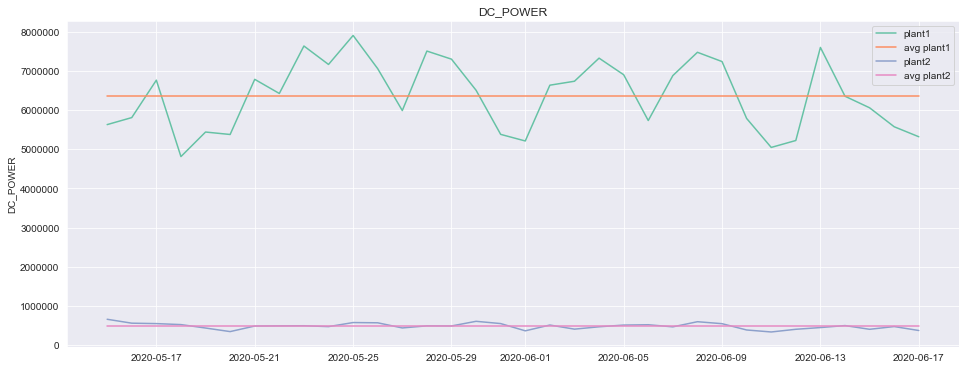

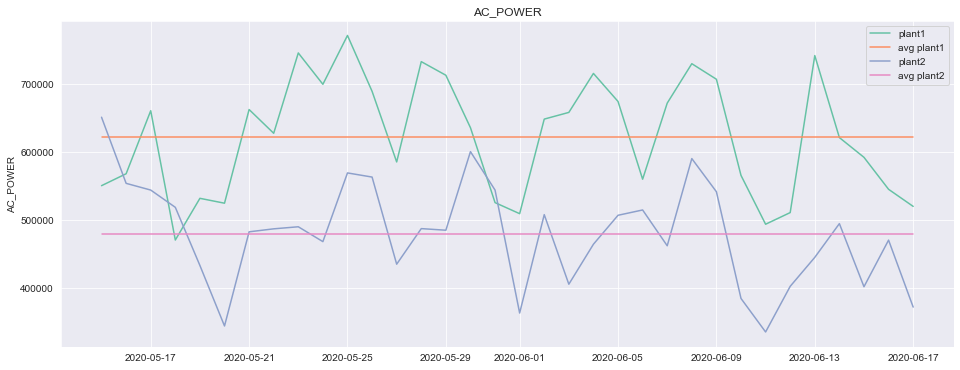

In [4]:
def groupDailyPower(df_generation):
    df = df_generation.groupby(['DATE_TIME']).sum()
    df = df.sort_index()
    index_date = pd.date_range(start=df.index[0].date(), end=df.index[-1].date())
    df_sort = df.groupby(by=[df.index.year, df.index.month, df.index.day], as_index=False).sum()
    df_sort.index = index_date
    return df_sort 
    
def showDailyPower(plant1, plant2, feature, label1, label2):
    df_sort1 = groupDailyPower(plant1)
    df_sort2 = groupDailyPower(plant2)
    
    plt.figure(figsize=(16, 6))
    plt.title(feature)
    sns.lineplot(x=df_sort1.index, y=feature, data=df_sort1, label=label1)
    sns.lineplot(x=df_sort1.index, y=df_sort1[feature].mean(), label='avg '+label1)
    sns.lineplot(x=df_sort1.index, y=feature, data=df_sort2, label=label2)
    sns.lineplot(x=df_sort1.index, y=df_sort2[feature].mean(), label='avg '+label2)
    
showDailyPower(df_generation1, df_generation2, 'DC_POWER', 'plant1', 'plant2')
showDailyPower(df_generation1, df_generation2, 'AC_POWER', 'plant1', 'plant2')

The linechart shows that there's a huge different in the amount of DC power between Plant 1 and Plant 2. On the other hand, there's a slight different in AC power both of them.

### Daily Power Inverting Efficiency

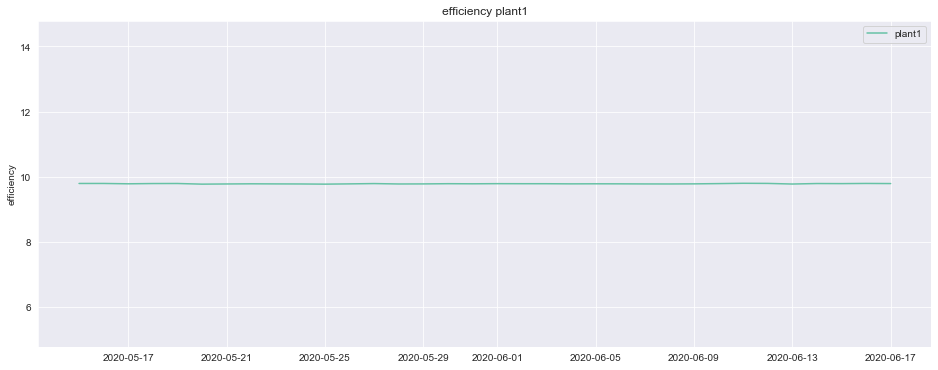

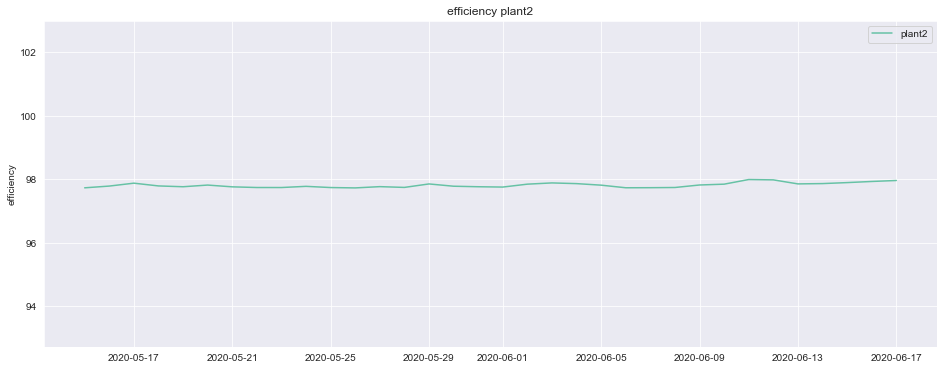

In [5]:
def powerEfficiency(df_generation, label):
    df = df_generation.groupby(['DATE_TIME']).sum()
    df = df.sort_index()
    index_date = pd.date_range(start=df.index[0].date(), end=df.index[-1].date())
    df_sort = df.groupby(by=[df.index.year, df.index.month, df.index.day], as_index=False).sum()
    df_sort['efficiency'] = df_sort['AC_POWER']*100/df_sort['DC_POWER']
    df_sort.index = index_date
    
    plt.figure(figsize=(16, 6))
    plt.ylim(df_sort['efficiency'].min()-5, df_sort['efficiency'].max()+5)
    plt.title('efficiency ' + label)
    sns.lineplot(x=df_sort.index, y='efficiency', data=df_sort, label=label)
    
powerEfficiency(df_generation1, 'plant1')
powerEfficiency(df_generation2, 'plant2')

The average of plant 2's inverter efficiency is about 98% but plant 1 is below 10%.

### Daily Weather Condition

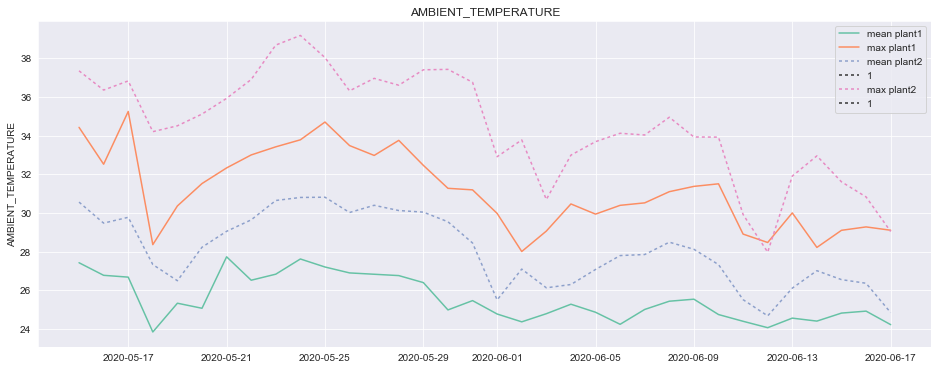

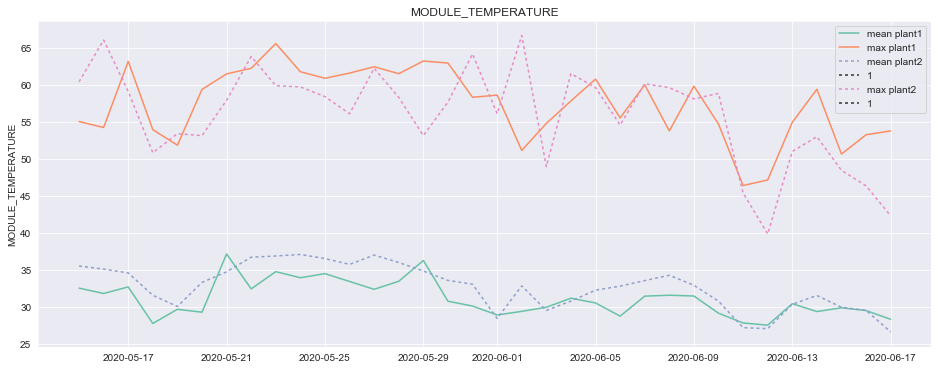

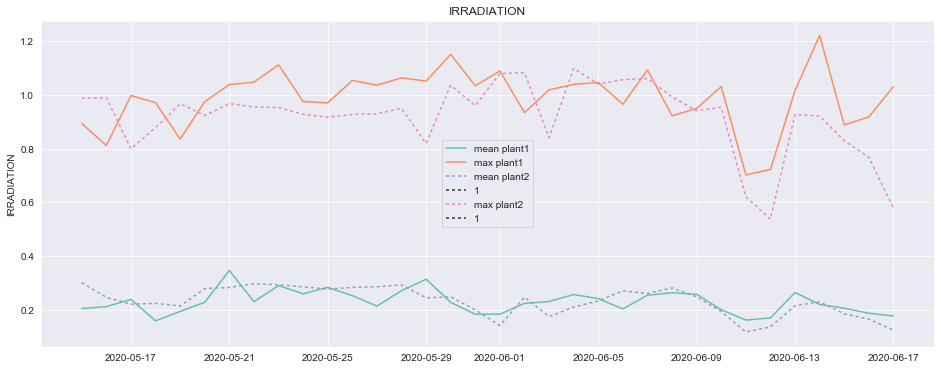

In [6]:
def groupDailyWeather(df_weather, operation):
    df = df_weather.groupby(['DATE_TIME']).last()
    df = df.sort_index()
    index_date = pd.date_range(start=df.index[0].date(), end=df.index[-1].date())
    
    if operation == 'mean':
        df_sort = df.groupby(by=[df.index.year, df.index.month, df.index.day], as_index=False).mean()
    elif operation == 'max':
        df_sort = df.groupby(by=[df.index.year, df.index.month, df.index.day], as_index=False).max()
        
    df_sort.index = index_date
    return df_sort 

def showDailyWeather(weather1, weather2, feature, label1, label2):
    df_sort1_mean = groupDailyWeather(weather1, 'mean')
    df_sort1_max = groupDailyWeather(weather1, 'max')
    df_sort2_mean = groupDailyWeather(weather2, 'mean')
    df_sort2_max = groupDailyWeather(weather2, 'max')
    
    plt.figure(figsize=(16, 6))
    plt.title(feature)
    sns.lineplot(x=df_sort1_mean.index, y=feature, data=df_sort1_mean, label='mean '+label1)
    sns.lineplot(x=df_sort1_mean.index, y=feature, data=df_sort1_max, label='max '+label1)
    sns.lineplot(x=df_sort2_mean.index, y=feature, data=df_sort2_mean, label='mean '+label2, style=1, dashes=[(2,2)])
    sns.lineplot(x=df_sort2_mean.index, y=feature, data=df_sort2_max, label='max '+label2, style=1,  dashes=[(2,2)])
    
showDailyWeather(df_weather1, df_weather2, 'AMBIENT_TEMPERATURE', 'plant1', 'plant2')
showDailyWeather(df_weather1, df_weather2, 'MODULE_TEMPERATURE', 'plant1', 'plant2')
showDailyWeather(df_weather1, df_weather2, 'IRRADIATION', 'plant1', 'plant2')

The graphs above show the change of environment condition in daily mean and max value. It tells that there's a slight different in ambient temperatures.

## 2. Build Model

To predict model, we can use a simpler model such as Naive Bayes by selecting 10 days in a row as features.

In [7]:
from sklearn.naive_bayes import GaussianNB

In [8]:
def prepareData(df_sort, feature):
    n_bins = 12
    bins = np.linspace(df_sort[feature].min(), df_sort[feature].max(), n_bins)
    binned = np.digitize(df_sort[feature], bins)
    binned_series = pd.Series(binned, index = df_sort[feature].index)
    
    bin_means = {}
    for binn in range(1,n_bins+1):
        bin_means[binn] = df_sort['AC_POWER'][binned == binn].mean()
        
    lagged_list = []
    for s in range(13):
        lagged_list.append(binned_series.shift(s))

    lagged_frame = pd.concat(lagged_list, 1).dropna()

    train_X = lagged_frame.iloc[:,1:]
    train_y = lagged_frame.iloc[:,0]
    
    return train_X, train_y, bin_means

In [9]:
# Generation 1
df_sort1 = groupDailyPower(df_generation1)
train_X1, train_y1, bin_means1 = prepareData(df_sort1, 'AC_POWER')

# Generation 2
df_sort2 = groupDailyPower(df_generation2)
train_X2, train_y2, bin_means2 = prepareData(df_sort2, 'AC_POWER')

In [10]:
# Generation 1
model1 = GaussianNB()
model1.fit(train_X1, train_y1)

# Generation 2
model2 = GaussianNB()
model2.fit(train_X2, train_y2)

GaussianNB(priors=None, var_smoothing=1e-09)

## 3. Predict 

In [11]:
def meanFromClass(bin_means, prediction):
    return(bin_means[prediction[0]])

def newPredict(last_y, last_x):
    last = last_y.astype(float)
    new_input = np.concatenate((last, last_x))[:12]
    return new_input

def newIndexDate(days, train_y):
    return pd.date_range(start=train_y.index[0].date(), end=train_y.index[-1].date() + dt.timedelta(days=days))

In [12]:
def prediction(train_X, train_y, model, bin_means, df_sort):
    num_next_days = 12
    pred_insample = model.predict(train_X)

    last = np.array([pred_insample[-1].astype(float)])
    last_X = np.array(train_X)[-1]
    new_input = np.concatenate((last, last_X))[:12]

    result_predict = []
    for i in range(num_next_days):
        result = model1.predict(new_input.reshape(1, -1))
        result_predict.append(result[0])
        new_input = newPredict(result, new_input)

    pred_insample = np.concatenate((pred_insample, np.array(result_predict)))
    new_index = newIndexDate(num_next_days, train_y)

    pred_insample = pd.DataFrame(pred_insample, index = new_index)
    resulting_prediction = pd.Series(np.nan, index = new_index)
    for row in range(len(pred_insample)):
        resulting_prediction.iloc[row] = meanFromClass(bin_means, pred_insample.values[row])

    plt.figure(figsize = (12,6))
    plt.plot(df_sort['AC_POWER'])
    plt.plot(resulting_prediction)

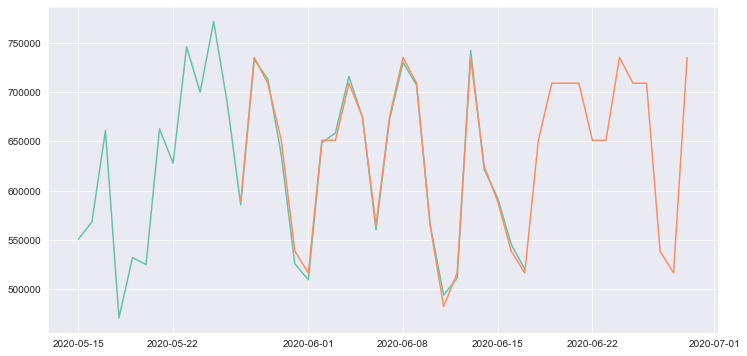

In [13]:
# Generation 1
prediction(train_X1, train_y1, model1, bin_means1, df_sort1)

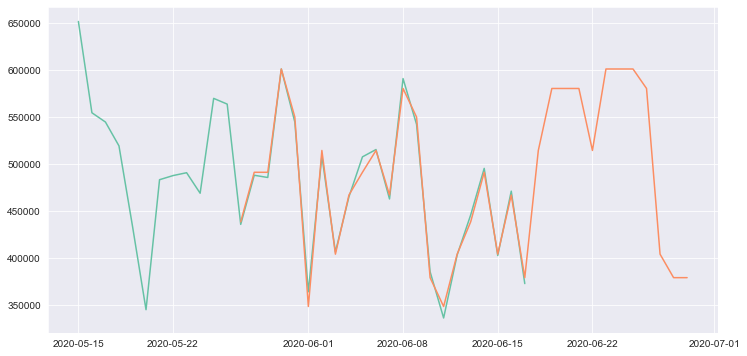

In [14]:
# Generation 2
prediction(train_X2, train_y2, model2, bin_means2, df_sort2)

## Conclusion

From the predictions above it seems overfit for generation 2 predictions, but it seems good for generation 1 predictions. It may happen because of the variety of the dataset. The prediction 1 can follow the pattern, but the pattern of prediction 2 is sligthly random.